In [1]:
import torch, os, copy, sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
import ipywidgets as widgets
from ipywidgets import interact
from IPython.display import clear_output
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
from matplotlib.ticker import FuncFormatter
from matplotlib.colors import TwoSlopeNorm, LinearSegmentedColormap


from src.mechanism_base import *
from src.model_base import EmbedMLP
from src.utils import cross_entropy_high_precision, acc_rate

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Loading on device: {device}")

plt.rcParams['mathtext.fontset'] = 'cm'
colors = ['#0D2758', '#60656F', '#DEA54B', '#A32015', '#347186']

Loading on device: cpu


In [2]:
# Define the base path where the model and data files are stored
base_path = '../src/saved_models/p_23_dmlp_512_Quad_random_scale_0.1_decay_0_08151413'  # Full random, Quad, Small Init, SGD

# Set model configuration parameters
d_vocab, d_model, d_mlp, act_type = 23, 23, 512, 'Quad'  # Vocabulary size, model dimension, MLP size, and activation type
p = d_vocab  # Assign vocabulary size to variable `p`

In [3]:
fourier_basis, fourier_basis_names = get_fourier_basis(p, device)
fourier_basis_unstd, _ = get_fourier_basis_unstd(p, device)

In [4]:
all_files = [os.path.join(base_path, f) for f in os.listdir(base_path) if os.path.isfile(os.path.join(base_path, f))]

loaded_files = {} # Initialize the dictionary to store the loaded files
exclude_files = {'final.pth', 'test_data.pth', 'train_data.pth'} # Define the files to exclude

# Loop through all files in the directory
for file_name in os.listdir(base_path):
    file_path = os.path.join(base_path, file_name)
    # Check if it's a file, has the correct extension, and is not in the exclude list
    if os.path.isfile(file_path) and file_name.endswith('.pth') and file_name not in exclude_files:
        # Extract the final ID from the filename (remove extension and convert to int)
        final_id = int(os.path.splitext(file_name)[0])
        # Load the file (assuming it's a PyTorch model)
        loaded_files[final_id] = torch.load(file_path, weights_only=True, map_location=device)["model"]
loaded_files = {key: loaded_files[key] for key in sorted(loaded_files)}

In [5]:
# Create a single list of all neuron‐records (dropping the model key)
all_neuron_records = []
sparse_level_ls =[]

for model in loaded_files.values():
    # Decode this model’s weights
    W_in_decode, W_out_decode, max_freq_ls = decode_weights(model, fourier_basis)
    d_mlp = W_in_decode.shape[0]
    sparse_level_ls.append((W_in_decode.norm(p=4, dim=1)**4/W_in_decode.norm(p=2, dim=1)**4).mean()/2 + (W_out_decode.norm(p=4, dim=1)**4/W_out_decode.norm(p=2, dim=1)**4).mean()/2)


    for neuron in range(d_mlp):
        coeff_in_scale, coeff_in_phi  = compute_neuron(neuron, max_freq_ls, W_in_decode)
        coeff_out_scale, coeff_out_phi = compute_neuron(neuron, max_freq_ls, W_out_decode)
        scale_diff = coeff_in_scale**2 - 2 * coeff_out_scale**2

        # Append just the neuron‐level info
        all_neuron_records.append({
            "neuron":     neuron,
            "frequency":  max_freq_ls[neuron],
            "scale_in":   coeff_in_scale,
            "phi_in":     coeff_in_phi,
            "scale_out":  coeff_out_scale,
            "phi_out":    coeff_out_phi,
            "scale_diff": scale_diff
        })

In [6]:
# specify the neuron you care about
neuron_id = 40  # change to your desired neuron index

# collect per‐model vectors
scales_list = []
diff_list   = []

for model in loaded_files.values():
    # decode all freqs for this model’s W_in
    scales, phis, psis = decode_scales_phis(model, fourier_basis)
    # pick out this neuron’s row
    scales_list.append(scales[neuron_id])  # Tensor[K+1]
    diff_list.append(normalize_to_pi(psis[neuron_id] - 2*phis[neuron_id]))    # Tensor[K+1]

# stack into two big tensors of shape (num_models, K+1)
scales_all = torch.stack(scales_list, dim=0)[:-10,1:]
diff_all   = torch.stack(diff_list,   dim=0)[:-10,1:]

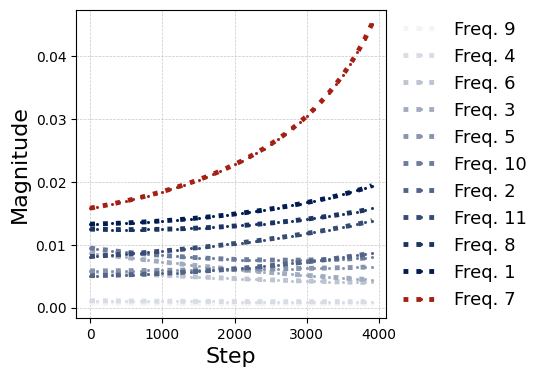

In [7]:
# your palette
colors = ['#0D2758', '#60656F', '#DEA54B', '#A32015', '#347186', '#0064E0']
base_rgb        = np.array(mcolors.to_rgb(colors[0]))
gray_rgb        = np.array(mcolors.to_rgb('white'))
highlight_color = colors[3]
max_freq        = max_freq_ls[neuron_id]-1   # frequency to highlight

# assume scales_all is already defined: Tensor[num_models, K+1]
scales_np = scales_all.cpu().numpy()
scales_np = scales_np[:160]
num_models, num_freqs = scales_np.shape
x = np.arange(num_models)

# order the non-highlight freqs by their final-scale value
final_scales  = scales_np[-1]
nonmax        = [f for f in range(num_freqs) if f != max_freq]
sorted_nonmax = sorted(nonmax, key=lambda f: final_scales[f])
M = len(sorted_nonmax)

# create a larger figure + main axes
fig, ax = plt.subplots(figsize=(4, 4))  # increased size

# plot non-highlight freqs in a gradient from white → base color
for idx, f in enumerate(sorted_nonmax):
    blend = idx / (M - 1) if M > 1 else 0.0
    col_rgb = (1 - blend -0.05) * gray_rgb + (blend +0.05)* base_rgb
    ax.plot(x, scales_np[:, f],
            color=col_rgb,
            linestyle=':',
            marker='x',
            linewidth=3.5,
            markersize=1.5,
            label=f"Freq. {f+1}")

# plot the highlighted max_freq
ax.plot(x, scales_np[:, max_freq],
        color=highlight_color,
        linestyle=':',
        marker='x',
        linewidth=3.5,
        markersize=1.5,
        label=f"Freq. {max_freq+1}")

ax.xaxis.set_major_formatter(FuncFormatter(lambda val, pos: f"{int(val*100)}"))

# put legend on the right, outside the plot
ax.legend(loc='upper left',
          bbox_to_anchor=(1.02, 1),
          borderaxespad=0.2,
          frameon=False,
          fontsize=13)

# grid & labels
ax.set_xlabel("Step", fontsize=16)
ax.set_ylabel("Magnitude", fontsize=16)
#ax.set_title(f"Neuron {neuron_id} scales across models", fontsize=14)
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.savefig('../figures/lottery_mech_magnitude.jpg', format='jpg', dpi=300, bbox_inches='tight')

plt.show()


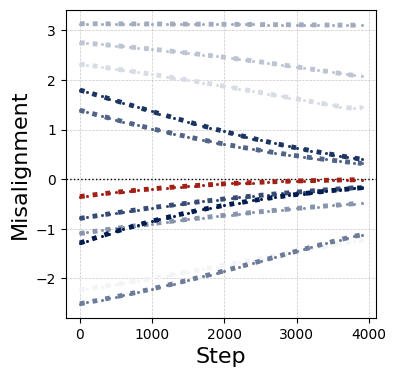

In [8]:
# assume diff_list is a torch.Tensor[num_models, K+1]
diff_np = diff_all.cpu().numpy()
diff_np = diff_np[:160]
num_models, num_freqs = diff_np.shape
x = np.arange(num_models)

# order the non-highlight freqs by their final diff value
final_diffs   = diff_np[-1]
M = len(sorted_nonmax)

# create a larger figure + main axes
fig, ax = plt.subplots(figsize=(4, 4))

ax.axhline(y=0,
           color='black',
           linewidth=1,
           linestyle='dotted')

# plot non-highlight freqs in a gradient from white → base color
for idx, f in enumerate(sorted_nonmax):
    blend = idx / (M - 1) if M > 1 else 0.0
    col_rgb = (1 - blend - 0.05) * gray_rgb + (blend + 0.05) * base_rgb
    ax.plot(x, diff_np[:, f],
            linestyle=':',
            marker='x',
            linewidth=3.5,
            markersize=1.5,
            color=col_rgb,
            label=f"Freq. {f}")

# plot the highlighted max_freq
ax.plot(x, diff_np[:, max_freq],
        linestyle=':',
        marker='x',
        linewidth=3.5,
        markersize=1.5,
        color=highlight_color,
        label=f"Freq. {max_freq}")

ax.xaxis.set_major_formatter(FuncFormatter(lambda val, pos: f"{int(val*100)}"))

# grid & labels
ax.set_xlabel("Step", fontsize=16)
ax.set_ylabel("Misalignment", fontsize=16)
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.savefig('../figures/lottery_mech_phase.jpg', format='jpg', dpi=300, bbox_inches='tight')

plt.show()


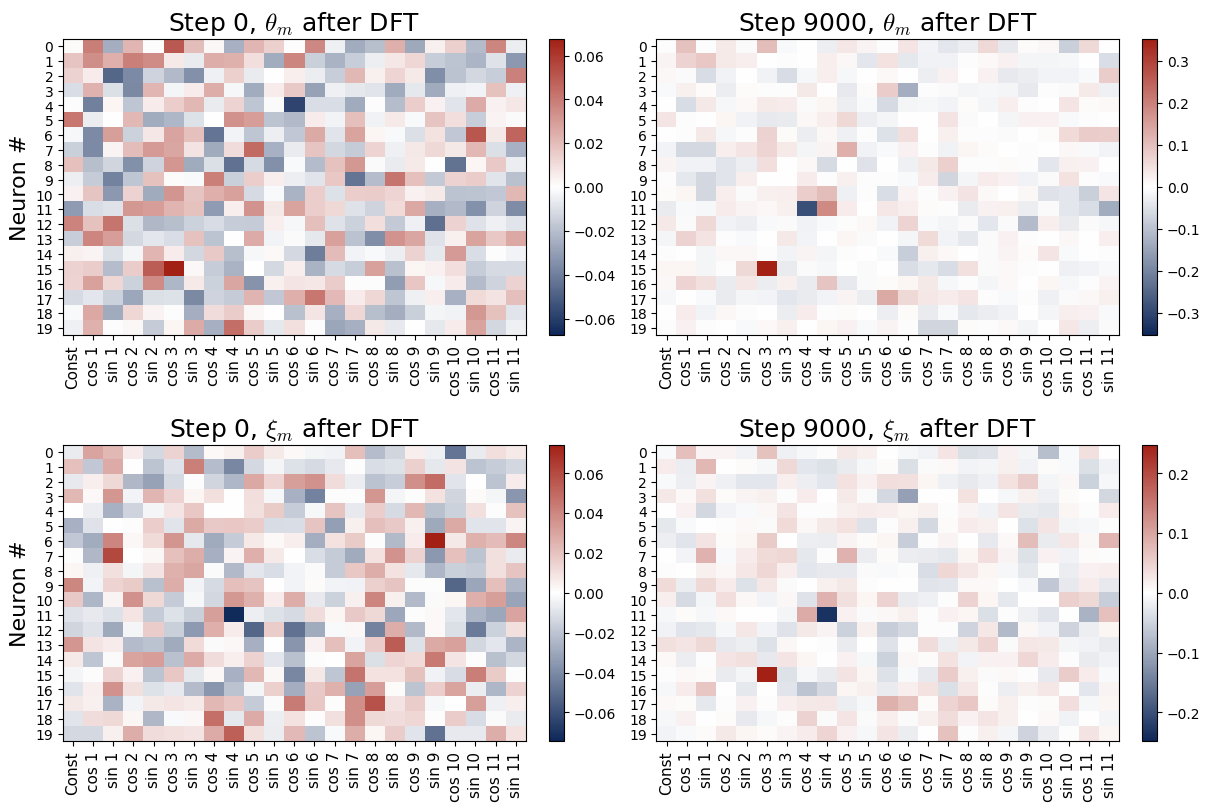

In [12]:
# Create a custom colormap that centers 'cividis' with white at zero
cividis_with_white = LinearSegmentedColormap.from_list(
    'cividis_white_center', 
    ['#0D2758', 'white', '#A32015'],  # Colors at low, middle, and high points in 'cividis'
    N=256
)

def plot_decoded_weights(
    loaded_files,
    fourier_basis,
    fourier_basis_names,
    keys,
    num_components=20
):
    """
    Plots decoded W_in and W_out for each key in `keys`.

    Parameters
    ----------
    loaded_files : list of dict
        Each element is a dict containing 'mlp.W_in' and 'mlp.W_out'.
    fourier_basis : np.ndarray
        Your Fourier basis matrix of shape (p, p).
    fourier_basis_names : list of str
        Names/labels for each Fourier mode (length p).
    keys : list of int
        Indices into loaded_files to plot.
    num_components : int, optional
        How many top components (rows) to show, by default 20.
    """
    n = len(keys)
    #fig, axes = plt.subplots(2, n, figsize=(18, 3.3 * n), gridspec_kw={"hspace": 0.05}, constrained_layout=True)
    fig, axes = plt.subplots(2, n, figsize=(12, 4 * n), gridspec_kw={"hspace": 0.05}, constrained_layout=True)

    # Ensure axes is always 2×n
    if n == 1:
        axes = axes.reshape(2, 1)

    x_locs = np.arange(len(fourier_basis_names))
    y_locs = np.arange(num_components)

    for col, key in enumerate(keys):
        W_in = loaded_files[key]['mlp.W_in']
        W_out = loaded_files[key]['mlp.W_out']

        # --- Decoded W_in on row 0, col `col`
        data_in = (W_in @ fourier_basis.T)[:num_components]
        abs_max_in = np.abs(data_in).max()
        ax_in = axes[0, col]
        im_in = ax_in.imshow(
            data_in,
            cmap=cividis_with_white,
            vmin=-abs_max_in,
            vmax= abs_max_in,
            aspect='auto'
        )
        ax_in.set_title(rf'Step {key}, $\theta_m$ after DFT', fontsize=18)
        ax_in.set_xticks(x_locs)
        ax_in.set_xticklabels(fourier_basis_names, rotation=90, fontsize=11)
        ax_in.set_yticks(y_locs)
        ax_in.set_yticklabels(y_locs)
        if key == 0: ax_in.set_ylabel('Neuron #', fontsize=16)
        fig.colorbar(im_in, ax=ax_in)

        # --- Decoded W_out on row 1, col `col`
        data_out = (W_out.T @ fourier_basis.T)[:num_components]
        abs_max_out = np.abs(data_out).max()
        ax_out = axes[1, col]
        im_out = ax_out.imshow(
            data_out,
            cmap=cividis_with_white,
            vmin=-abs_max_out,
            vmax= abs_max_out,
            aspect='auto'
        )
        ax_out.set_title(rf'Step {key}, $\xi_m$ after DFT', fontsize=18)
        ax_out.set_xticks(x_locs)
        ax_out.set_xticklabels(fourier_basis_names, rotation=90, fontsize=11)
        ax_out.set_yticks(y_locs)
        ax_out.set_yticklabels(y_locs)
        if key == 0: ax_out.set_ylabel('Neuron #', fontsize=16)
        fig.colorbar(im_out, ax=ax_out)

    #plt.tight_layout()
    #plt.savefig('../figures/single_freq_relu.jpg', format='jpg', dpi=300, bbox_inches='tight')
    plt.show()


# Example usage:
keys = [0, 9000]  # whatever subset of loaded_files you want
plot_decoded_weights(loaded_files, fourier_basis, fourier_basis_names, keys, num_components=20)

In [9]:
def gradient_update(theta, xi, init_k, p, device):
    # Compute Fourier coefficients for theta and xi
    fourier_basis, _ = get_fourier_basis(p, device)
    # Ensure that the fourier_basis has the same dtype as theta and xi
    fourier_basis = fourier_basis.to(theta.dtype)
    theta_coeff = fourier_basis @ theta  
    xi_coeff    = fourier_basis @ xi

    # --- For theta: extract the 2-coefficient vector for neuron 'init_k'
    # Using list indexing to extract two rows from theta_coeff.
    neuron_coeff_theta = theta_coeff[[init_k * 2 - 1, init_k * 2]]
    alpha = np.sqrt(2/p) * torch.sqrt(torch.sum(neuron_coeff_theta.pow(2))).item()
    phi = np.arctan2(-neuron_coeff_theta[1].item(), neuron_coeff_theta[0].item())
    # print(alpha)
    # print(phi)

    # --- For xi: similarly, extract a 2-element vector (correcting psi_coeff -> xi_coeff)
    neuron_coeff_xi = xi_coeff[[init_k * 2 - 1, init_k * 2]]
    beta = np.sqrt(2/p) * torch.sqrt(torch.sum(neuron_coeff_xi.pow(2))).item()
    psi = np.arctan2(-neuron_coeff_xi[1].item(), neuron_coeff_xi[0].item())

    # --- Compute gradients over the p Fourier modes.
    w_k = 2 * np.pi * init_k / p
    grad_theta = torch.tensor(
        [2 * p * alpha * beta * np.cos(w_k * j + psi - phi) for j in range(p)],
        device=device
    )
    grad_xi = torch.tensor(
        [p * alpha**2 * np.cos(w_k * j + 2 * phi) for j in range(p)],
        device=device
    )

    return grad_theta, grad_xi

def simulate_gradient_flow(theta, xi, init_k, p, num_steps, learning_rate, device):
    # Lists to store the history (optional)
    theta_history = [theta.clone()]
    xi_history = [xi.clone()]
    
    for step in range(num_steps):
        grad_theta, grad_xi = gradient_update(theta, xi, init_k, p, device)
        # Update parameters using a simple Euler update (gradient descent style)
        theta = theta + learning_rate * grad_theta
        xi = xi + learning_rate * grad_xi
        
        theta_history.append(theta.clone())
        xi_history.append(xi.clone())
        
    return theta_history, xi_history

In [15]:
import pandas as pd

# Simulation hyper-params
device        = torch.device("cpu")
p             = 23
init_k        = 1
init_psi      = 0.0
num_steps     = 100
learning_rate = 0.01

# Experiment grid
initial_scales = np.linspace(0.01, 0.02, num=30)               # whatever scales you want
phi0_vals      = np.linspace(0, np.pi, num=30)   # e.g. 21 values from 0 to 2π

# Pre-compute Fourier basis once
fourier_basis, _ = get_fourier_basis(p, device)
fourier_basis = fourier_basis.to(torch.get_default_dtype())
factor = np.sqrt(2/p)

results = []

for scale in initial_scales:
    for phi0 in phi0_vals:
        # 1) initialize theta, xi
        w_k   = 2*np.pi*init_k/p
        theta = scale * torch.tensor([np.cos(w_k*j + phi0) for j in range(p)], device=device)
        xi    = scale * torch.tensor([np.cos(w_k*j + init_psi) for j in range(p)], device=device)
        
        # 2) run gradient flow
        th_hist, xi_hist = simulate_gradient_flow(theta, xi, init_k, p, num_steps, learning_rate, device)
        
        # 3) take the last iterate
        th_final, xi_final = th_hist[-1], xi_hist[-1]
        
        # 4) compute final beta and psi, phi
        coeffs_th = fourier_basis.to(th_final.dtype) @ th_final
        coeffs_xi = fourier_basis.to(th_final.dtype) @ xi_final
        idx = [init_k*2-1, init_k*2]
        th_n = coeffs_th[idx]
        xi_n = coeffs_xi[idx]
        
        phi_f = np.arctan2(-th_n[1].item(), th_n[0].item())
        beta_f = torch.norm(xi_n).item() * np.sqrt(2/p)
        psi_f  = np.arctan2(-xi_n[1].item(), xi_n[0].item())
        
        delta_f = normalize_to_pi(2*phi_f - psi_f)
        
        results.append({
            "init_scale": scale,
            "init_diff":  2*phi0,
            "beta_f":  beta_f,
            "delta_f": delta_f
        })

# 5) collect into a DataFrame
df = pd.DataFrame(results)
print(df)

     init_scale  init_diff    beta_f       delta_f
0          0.01   0.000000  0.013967 -6.015144e-08
1          0.01   0.216662  0.013910  5.349484e-02
2          0.01   0.433323  0.013742  1.094956e-01
3          0.01   0.649985  0.013468  1.706796e-01
4          0.01   0.866646  0.013098  2.400848e-01
..          ...        ...       ...           ...
895        0.02   5.416539  0.050549 -2.437592e-02
896        0.02   5.633201  0.054462 -1.522031e-02
897        0.02   5.849862  0.057545 -8.850920e-03
898        0.02   6.066524  0.059525 -4.066940e-03
899        0.02   6.283185  0.060207 -3.801330e-08

[900 rows x 4 columns]


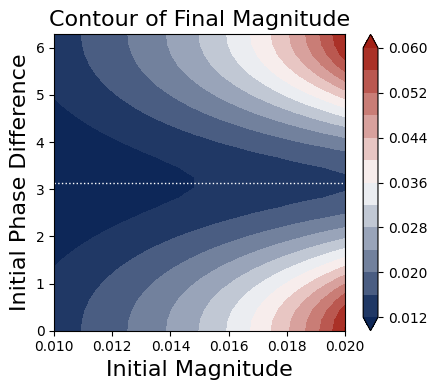

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Custom colormap
cividis_with_white = LinearSegmentedColormap.from_list(
    'cividis_white_center',
    ['#0D2758', 'white', '#A32015'],
    N=256
)

# (Re)pivot your DataFrame into a grid
beta_grid = df.pivot(index="init_diff", columns="init_scale", values="beta_f")

# Build mesh for contour
X, Y = np.meshgrid(beta_grid.columns.values, beta_grid.index.values)
Z = beta_grid.values

# Plot the filled contour
plt.figure(figsize=(4.5, 4))
cf = plt.contourf(
    X, Y, Z,
    levels=12,
    cmap=cividis_with_white,
    extend='both'
)

# Add white horizontal line at y = π
plt.axhline(y=np.pi, color='white', linewidth=1, linestyle=':')

plt.xlabel("Initial Magnitude", fontsize=16)
plt.ylabel("Initial Phase Difference", fontsize=16)
plt.title("Contour of Final Magnitude", fontsize=16)
plt.colorbar(cf)
plt.tight_layout()

# Save to file
plt.savefig('../figures/lottery_beta_contour.jpg', format='jpg', dpi=300, bbox_inches='tight')
plt.show()

